In [113]:
import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.integrate import solve_ivp

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [114]:
m = 0.58  # masa piłki [kg]
l = 7.24  # linia rzutów za trzy punkty (od środka obręczy) [m] TODO: sprawdzić czy faktycznie jest do środka
h0 = 3.05  # wysokość na jakiej umieszczone są kosze [m]
hk = 2.7  # wysokość z jakiej rzucana jest piłka [m]
cx = cy = 0.45  # współczynniki oporu TODO: sprawdzić ocb z nimi
D0 = 0.45  # średnia obręczy kosza [m] TODO: sprawdzić czy dobrze w obliczeniach bo było wcześniej jako średnica piłki
v0 = 15.0  # prędkość początkowa piłki [m/s]
rho_p = 1.2  # gęstość powietrza [kg/m^3]
alpha = 15  # kąt w chwili rzutu
air_resistance_model = 'kwadratowy'  # liniowy / kwadratowy  TODO: inne kąty są dobre dla innych modeli!
g = 9.81  # przyspieszenie ziemskie [m/s^2]
ball_radius = 0.12  # promień piłki [m]
radius = D0 / 2  # promień obręczy kosza [m] TODO: sprawdzić czy dobrze w obliczeniach bo było wcześniej jako średnica piłki
area = np.pi * radius ** 2  # pole powierzchni kosza [m^2] TODO: sprawdzić czy dobrze w obliczeniach bo było wcześniej jako średnica piłki
circumference = 2 * np.pi * radius  # obwód kosza [m]

In [115]:
def calculate_motion_derivatives(t, y, air_resistance_model):
    """
    Oblicza pochodne równań ruchu z uwzględnieniem oporu powietrza do późniejszej symulacji ruchu.

    Parametery:
    t: float
        Czas [s]
    y: list
        Lista stanów początkowych [x0, vx0, y0, vy0]
    alpha: float
        Kąt w chwili rzutu wyrażony w radianach
    air_resistance_model: str
        'liniowy' lub 'kwadratowy' model oporu powietrza

    Wyjście:
    dydt: list
        Pochodne [vx, ax, vy, ay]
    """
    x, vx, y, vy = y
    # v = np.sqrt(vx**2 + vy**2)  # aktualna prędkość

    if air_resistance_model == 'liniowy':
        force_x = 0.5 * cx * rho_p * area * vx
        force_y = 0.5 * cy * rho_p * area * vy
    elif air_resistance_model == 'kwadratowy':
        force_x = 0.5 * cx * rho_p * area * pow(vx, 2)
        force_y = 0.5 * cy * rho_p * area * pow(vy, 2)
    else:
        raise ValueError('Nieprawidłowy model oporu powietrza (do wyboru liniowy lub kwadratowy).')

    ax = -force_x / m
    ay = -g - (force_y / m)

    return [vx, ax, vy, ay]

In [116]:
def calculate_trajectory(v0, alpha, air_resistance_model):
    vx0 = v0 * np.cos(alpha)  # 'x' z kropką nad nim oznacza dx/dt (pochodną czasową x)
    vy0 = v0 * np.sin(alpha)
    initial_state = [0, vx0, hk, vy0]  # lista stanów początkowych [x0, vx0, y0, vy0]
    time_span = (0, 5)  # przedział czasu symulacji
    t_eval = np.linspace(*time_span, time_span[1] * 100)  # punkty w których obliczamy wartości
    result = solve_ivp(calculate_motion_derivatives, time_span, initial_state, args=(air_resistance_model,), t_eval=t_eval, dense_output=True)  # rozwiązania równania różniczkowego na przestrzeni czasu
    return result

In [117]:
def check_stop_condition(x, y):
    if np.abs(x - l) < radius and h0 - ball_radius <= y <= h0 + ball_radius:  # TODO: poprawić warunek bo ten sprawdza tylko styk z obręczą
        return True
    if y <= 0:
        return True
    return False

In [118]:
def calculate_stop_frame(x, y):
    for i in range(len(x)):
        if check_stop_condition(x[i], y[i]):
            return x[:i+1], y[:i+1]
    return x, y

In [119]:
def animate_trajectory(result):
    x, y = result.y[0], result.y[2]
    x, y = calculate_stop_frame(x, y)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 7)

    basket_left = l - radius
    basket_right = l + radius
    ax.plot([basket_left, basket_right], [h0, h0], color='brown', linewidth=3, label='Obręcz kosza')

    ax.plot([0, 0], [0, hk], color='grey', linewidth=3)
    ax.scatter(0, hk + 0.2, color='grey', s=200, label='Zawodnik')

    trajectory_line, = ax.plot([], [], 'b-', label='Trajektoria lotu')
    ball, = ax.plot([], [], 'yo', markersize=12, label='Piłka')

    ax.set_title('Animacja trajektorii lotu piłki')
    ax.set_xlabel('Odległość [m]')
    ax.set_ylabel('Wysokość [m]')
    ax.legend()
    ax.grid()

    def animate(i):
        trajectory_line.set_data(x[:i+1], y[:i+1])
        ball.set_data([x[i]], [y[i]])
    
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x))
    return anim

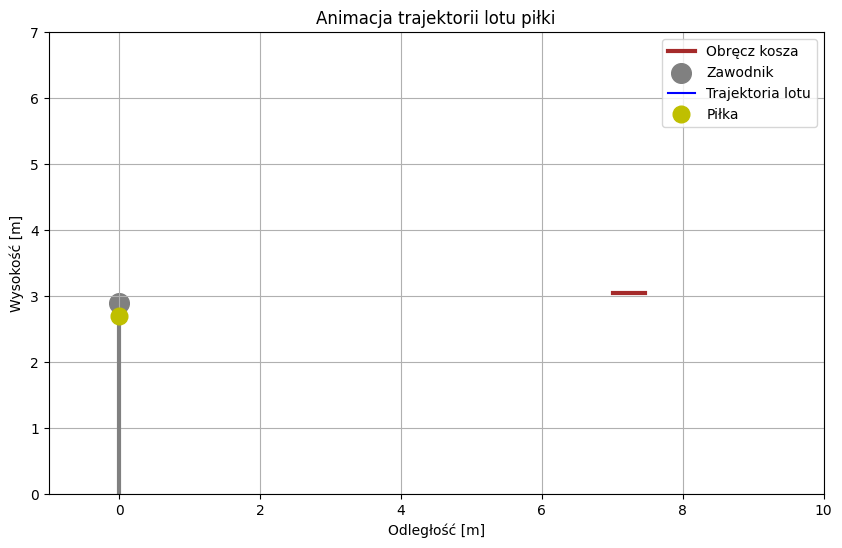

In [120]:
trajectory = calculate_trajectory(v0, np.radians(alpha), air_resistance_model)
animation = animate_trajectory(trajectory)
HTML(animation.to_jshtml())